# TP noté 1 : Régression linéaire #

Les librairies nécessaires pour lancer le notebook sont :
* pandas
* matplotlib
* numpy
* scipy


In [1]:
#import all key libraries
import pandas as pd                 #used for dataframe manipulation
import matplotlib.pyplot as plt     #used for plotting graphs
import matplotlib as mpl
import numpy as np                  #used for array manipulation
from scipy.stats import t as ttest  #used to measure t test
from scipy import stats             #used to get regression performace
from sklearn import linear_model
from sklearn.metrics import r2_score
from mpl_toolkits import mplot3d

1)  Importer la base de données _**“invest.txt”**_ et l’afficher dans une forme lisible, e.g. une table contenant les 5 premières observations.

In [2]:
invest_df = pd.read_csv('https://bitbucket.org/portierf/shared_files/downloads/invest.txt', sep = ' ')  #import invest.txt file
invest_df.head(5) # display dataframe

,year,gnp,invest,cpi,interest
0,1968,873.4,133.3,82.54,5.16
1,1969,944.0,149.3,86.79,5.87
2,1970,992.7,144.2,91.45,5.95
3,1971,1077.6,166.4,96.01,4.88
4,1972,1185.9,195.0,100.00,4.50


2) Réaliser le graphe suivant : la variable “Gross National Product” (GNP, column “gnp”) est en abscisse et la variable “Investment” (column “invest”) est en ordonnée. Transformer les 2 variables précédentes en échelle logarithmique. Nous travaillerons désormais avec les 2 nouvelles variables.

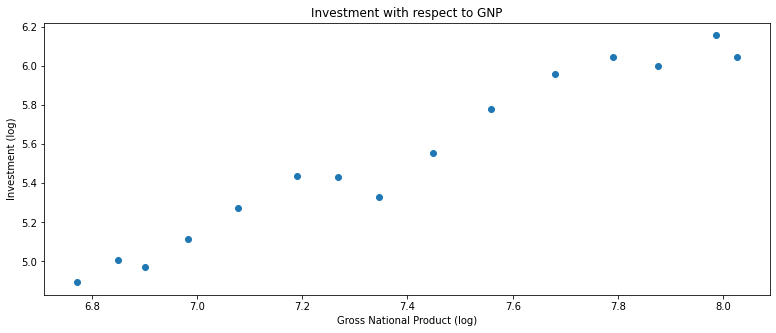

In [3]:
#take log of gnp and invest and add to the dataframe
invest_df['log_gnp'] = np.log(invest_df["gnp"])
invest_df['log_invest'] = np.log(invest_df["invest"])
log_gnp = invest_df['log_gnp']
log_invest = invest_df['log_invest']


plt.rcParams['figure.figsize'] = [13, 5]# set parameter for figure display
figs = plt.figure()
fig1 = figs.add_subplot()
plt.scatter(log_gnp,log_invest)
plt.xlabel("Gross National Product (log)")
plt.ylabel("Investment (log)")
plt.title("Investment with respect to GNP"); # Semicolon mutes Jupyter outputs
plt.show();

3) Pour la régression de ”Investment” (variable à expliquer, output) sur ”GNP” (variable explicative, covariable),
estimer l’intercept et la pente, leurs écart-types, ainsi que le coefficient de détermination. Les afficher dans une
forme lisible.
Nous allons utilise les equation:
* $\widehat{\beta_{0}}=\bar{y}-(\widehat{\beta_{1}} \bar{x})$   (eq 1) *pour calculer theta_0*  <br>
* $\widehat{\beta_{0}}=\frac{\sum_{i=1}^{n}\left(x_{i}-\bar{x}\right)\left(y_{i}-\bar{y}\right)}{\sum_{i=1}^{n}\left(x_{i}-\bar{x}\right)^{2}}$ (eq 2) *pour calculer theta_1*
* $\widehat{\sigma}=\sqrt{\frac{\sum(Y-\hat{Y})^{2}}{n-2}}$ (eq 3) *pour calculer sigma*
* $\widehat{\operatorname{se}}(\hat{\beta_{0}})=\sqrt{\frac{\hat{\sigma}^{2}}{\frac{1}{n}+\sum_{i}\left(x_{i}-\bar{x}\right)^{2}}}$ (eq 4) *pour l'ecart type de theta_0*
* $\widehat{\operatorname{se}}(\hat{\beta_{1}})=\sqrt{\frac{\hat{\sigma}^{2}}{\sum_{i}\left(x_{i}-\bar{x}\right)^{2}}}$ (eq 5) *pour l'ecart type de theta_1*
* $R^{2}=1-\frac{R S S}{T S S}$ (eq 6) *pour calculer le coefficient de détermination*
* $R S S=\sum_{i=1}^{n}\left(y_{i}-f\left(x_{i}\right)\right)^{2}$ (eq 7) *pour calculer le coefficient de détermination*
* $\mathrm{TSS}=\sum_{i=1}^{n}\left(y_{i}-\bar{y}\right)^{2} $ (eq 8) *pour calculer le coefficient de détermination*


In [4]:
X = np.array(log_gnp)
Y = np.array(log_invest)
n = len(Y)

mean_y = np.mean(Y)
mean_x = np.mean(X)

theta_1 = ( ((X-mean_x)*(Y-mean_y)).sum() ) / ((X-mean_x)**2).sum()  #eq 2
theta_0 = mean_y - (theta_1 * mean_x) #eq 1

Y_chap = theta_0 + (theta_1 * X) #calculer les valeurs de Y chap

E = Y - Y_chap
rss = ((Y - Y_chap)**2).sum()
rse = np.sqrt(rss/(n-2))
sigma = rse #eq 3

sd_theta_0_squared = (sigma**2) * ((1/n) + (mean_x**2)/((X-mean_x)**2).sum() )
sd_theta_0 = np.sqrt(sd_theta_0_squared) #eq 4

sd_theta_1_squared = (sigma**2)/((X-mean_x)**2).sum()
sd_theta_1 = np.sqrt(sd_theta_1_squared) #eq 4

tss = ((Y-mean_y)**2).sum()
r2 = (tss-rss)/tss #eq 6

print(f'Estimation and standard deviation for singular linear regression model with R\N{SUPERSCRIPT TWO} = {r2}')
data_3 = { 'Names' : ["theta_0", "theta_1"],
         "Estimation" : [theta_0, theta_1],
         "Écart-types" : [sd_theta_0, sd_theta_1]}
displayFrame_3 = pd.DataFrame.from_dict(data_3).set_index('Names')
displayFrame_3.index.name = None # removes line "names" from display
displayFrame_3.head()

Estimation and standard deviation for singular linear regression model with R² = 0.9627572956057855


,Estimation,Écart-types
theta_0,-1.963591,0.409547
theta_1,1.015281,0.055383


4)La pente estimée précédemment est-elle statistiquement significative? On fera un test de student (t-test). Donner la
 valeur de la statistique de test ainsi que la p-valeur. <br>
 Nous allons utilise l'equation $T_{i} = \frac{\sqrt{n}\widehat{\beta_{1}}}{\sqrt{\widehat{\sigma}G^{-1}_{ii}}}$ pour calculer le T-Test

In [5]:
Z = np.stack( (np.ones(n) , pd.Series.to_numpy(log_gnp)) ).T
G = np.dot(Z.T,Z)/n #matric de gram
inv_G = np.linalg.inv(G)
t = (np.sqrt(n)*theta_1)/np.sqrt((sigma**2)*inv_G[1,1])
p = 2*(1-ttest.cdf(t,n-2))
print(f'T-score : {t}')
print(f'P-score : {p}')
print(f'Le P-score obenu est {t/p:.2e} fois plus petit que le t-score,\n'
      f' la pente estimée précédemment est donc statistiquement\n significative\n'
      f'L\'hypothèse null (il n\'y a pas de correlation entre X et Theta 1) peut être rejeté')

T-score : 18.33198445686521
P-score : 1.1363709973011282e-10
Le P-score obenu est 1.61e+11 fois plus petit que le t-score,
 la pente estimée précédemment est donc statistiquement
 significative
L'hypothèse null (il n'y a pas de correlation entre X et Theta 1) peut être rejeté


5)Pour GNP égal à 1000, estimer l’investissement prédit par le modèle. Pour GNP égal à 1000, donner l’intervalle de
confiance pour la valeur prédite et l’intervalle de confiance pour la variable à expliquer “Investment”, au niveau 90%.
On pourra se référer à la section 3.1.3 “Confidence intervals for the predicted values” du polycopié dans laquelle
chaque intervalle est défini, CI(z) et PI(z), respectivement (avec les notations du polycopié, z = (1, 1000)T).

Pour faire ceci nous allons utiliser les equation:
* $\operatorname{CI}(z)=z^{T} \widehat{\theta} \pm t_{n-p-1}(1-\alpha / 2) \widehat{\sigma} \sqrt{z^{T}\left(Z^{T} Z\right)^{-1} z}$ (eq 9) *pour calculer l’intervalle de confiance pour la valeur prédite*
* $\operatorname{PI}(z)=z^{T} \widehat{\theta} \pm t_{n-p-1}(1-\alpha / 2) \widehat{\sigma} \sqrt{1+z^{T}\left(Z^{T} Z\right)^{-1} z}$ (eq 10) *pour calculer l’intervalle de confiance pour la variable à expliquer*


In [6]:
alpha = 0.10
theta_chap = np.array([theta_0,theta_1]).reshape(2,1)
z = np.array([1,np.log(1000)]).reshape(2,1)

# predicted values for given z
z = np.array([1,np.log(1000)]).reshape(2,1)
predicted_y =np.dot(z.T,theta_chap)

# estimate CI (l’intervalle de confiance pour la valeur prédite) eq 9
CI_diff = ttest.ppf(1-alpha/2,n-2)*sigma*np.sqrt( np.linalg.multi_dot([ z.T, np.linalg.inv(np.dot(Z.T,Z)),z]) )
y_CI_top = np.dot(z.T,theta_chap) +CI_diff
y_CI_bot = np.dot(z.T,theta_chap) -CI_diff

# estimate PI (’intervalle de confiance pour la variable à expliquer) eq 9
PI_diff = ttest.ppf(1-alpha/2,n-2)*sigma*np.sqrt(1+ np.linalg.multi_dot([ z.T, np.linalg.inv(np.dot(Z.T,Z)),z]) )
y_PI_top = np.dot(z.T,theta_chap) + PI_diff
y_PI_bot = np.dot(z.T,theta_chap) - PI_diff

print(f'The predicted value for a GNP equal to 1000 is {predicted_y[0][0]:.4f} or {np.exp(predicted_y)[0][0]:.4f} in '
      f'non log format')
data_5 = { 'Names' : ["Minimum", "Maximiun"],
         "CI" : [y_CI_bot[0][0], y_CI_top[0][0]],
         "PO" : [y_PI_bot[0][0], y_PI_top[0][0]]}
displayFrame_5 = pd.DataFrame.from_dict(data_5).set_index('Names')
displayFrame_5.index.name = None # removes line "names" from display
displayFrame_5.head()

The predicted value for a GNP equal to 1000 is 5.0497 or 155.9794 in non log format


,CI,PO
Minimum,4.988223,4.882820
Maximiun,5.111225,5.216628


6)Sur un graphe avec échelle logarithmique, avec GNP en abscisse et investment en ordonnée, tracer les données, la droite de régression, ainsi que les intervalle CI et PI (pour toutes les valeurs de log(GNP) comprises entre le maximum et le minimum observé sur les données)


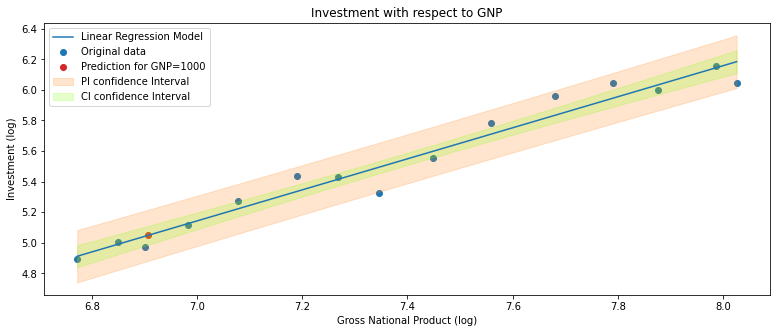

In [7]:
# to answer this question we will measure PI and CI for multiple points
PI_diff = ttest.ppf(1-alpha/2,n-2)*\
          sigma*np.sqrt(1+ np.diagonal(np.linalg.multi_dot([ Z, np.linalg.inv(np.dot(Z.T,Z)),Z.T])).reshape(15,1) )
Y_PI_top = np.dot(Z,theta_chap) + PI_diff
Y_PI_bot = np.dot(Z,theta_chap) - PI_diff

CI_diff = ttest.ppf(1-alpha/2,n-2)*\
          sigma*np.sqrt( np.diagonal(np.linalg.multi_dot([ Z, np.linalg.inv(np.dot(Z.T,Z)),Z.T])).reshape(15,1) )
Y_CI_top = np.dot(Z,theta_chap) +CI_diff
Y_CI_bot = np.dot(Z,theta_chap) -CI_diff

figs = plt.figure()
fig2 = figs.add_subplot()
plt.scatter(X,log_invest, label='Original data')
plt.scatter(np.log(1000),predicted_y[0][0] ,color='tab:red',label='Prediction for GNP=1000')
plt.plot(X,Y_chap, label='Linear Regression Model')

plt.fill_between(X.flatten(), Y_PI_bot.flatten(),Y_PI_top.flatten(),color='tab:orange',alpha=0.2,
                 label='PI confidence Interval')
plt.fill_between(X.flatten(), Y_CI_bot.flatten(),Y_CI_top.flatten(),color='#7FFF00',alpha=0.2,
                 label='CI confidence Interval')

plt.xlabel("Gross National Product (log)")
plt.ylabel("Investment (log)")
plt.title("Investment with respect to GNP")

plt.legend(loc = 2); # Semicolon mutes Jupyter outputs


7) En utilisant des classes/librairies existantes, donner l’intercept, la pente, le coefficient de dé- termination ainsi que l’investissement prédit par le modèle quand GNP vaut 1000. La classe LinearRegression() de sklearn.linear_model est suggérée mais pas obligatoire. Vérifier que les valeurs calculées ici coïncident avec celles des questions précédentes.


In [8]:
slope, intercept, r_value, p_value, std_err = stats.linregress(X,Y)
print('The following tables displays a comparison between the measured values and the one given by scikit-learn')
data_5 = { 'Names' : ["My values", "scikit-learn"],
           "slope" : [theta_chap[1][0], slope],
       "intercept" : [theta_chap[0][0], intercept],
         "R\u00B2" : [r2, r_value**2],
         "Prediction for GNP=1000" : [predicted_y[0][0], slope*np.log(1000)+intercept],
         "p_value" : [p, p_value]}
displayFrame_5 = pd.DataFrame.from_dict(data_5).set_index('Names')
displayFrame_5.index.name = None # removes line "names" from display
displayFrame_5.head()

The following tables displays a comparison between the measured values and the one given by scikit-learn


,slope,intercept,R²,Prediction for GNP=1000,p_value
My values,1.015281,-1.963591,0.962757,5.049724,1.136371e-10
scikit-learn,1.015281,-1.963591,0.962757,5.049724,1.136372e-10


8)Sur un graphe avec échelle logarithmique, avec GNP en abscisse et investment en ordonnée, tracer les données, la droite de régression, ainsi que l’investissement prédit par le modèle quand GNP vaut 1000 (on donnera à ce point une couleur différente).

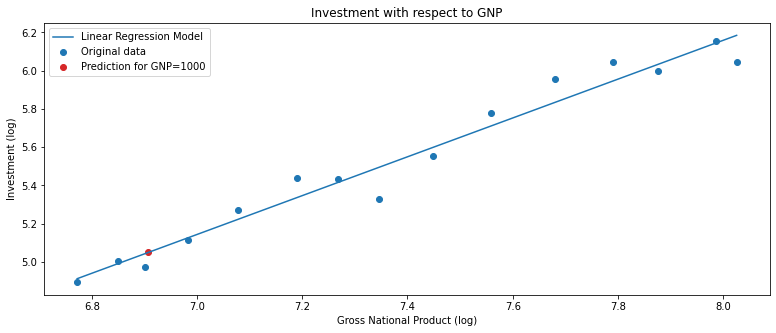

In [9]:
figs = plt.figure()
fig2 = figs.add_subplot()
plt.scatter(X,log_invest, label='Original data')
plt.scatter(np.log(1000),predicted_y[0][0] ,color='tab:red',label='Prediction for GNP=1000')
plt.plot(X,Y_chap, label='Linear Regression Model')

plt.xlabel("Gross National Product (log)")
plt.ylabel("Investment (log)")
plt.title("Investment with respect to GNP")

plt.legend(loc = 2); # Semicolon mutes Jupyter outputs


9) Pour la régression de Investment sur GNP et interest, calculer la matrice de Gram non standardisée $Z^TZ$. Est-elle de rang plein ?

In [10]:
X_0 = np.ones(len(invest_df['log_invest']))
X_1 = np.array(invest_df['log_gnp'])
X_2 = np.array(invest_df['interest'])
Y = np.array(invest_df['log_invest'])

Z = np.stack((X_0,X_1,X_2)).T
G = np.dot(Z.T,Z)
u, s, vh = np.linalg.svd(G)


print(f"The {G.shape} Gram matrix is of rank {np.linalg.matrix_rank(G)} so therefore full rank.\n"
      f"However looking at the singular values :\n{s}\n indicate the matrix is very close to rank 2")

The (3, 3) Gram matrix is of rank 3 so therefore full rank.
However looking at the singular values :
[1.73787190e+03 4.12140362e+01 1.82369697e-02]
 indicate the matrix is very close to rank 2


10) Pour la régression de Investment sur GNP et interest, estimer les 3 coefficients et leurs écart- types ainsi que le coefficient de détermination. En plus, faire un test de Student de significativité de chaque coefficient (donner la statistique de test et la p-valeur). Afficher les résultats dans une forme convenable. Discuter de la significativité des coefficients.
* $\widehat{\beta}= (Z^{T}Z)^{-1}Z^{T}Y $ (eq 11) *pour estimer les coefficients*

In [11]:
B = np.linalg.multi_dot((np.linalg.inv(np.dot(Z.T, Z)), Z.T, Y))#eq 11
Y_chap = np.dot(Z,B)

n = len(Y)
E = Y - Y_chap
rss = (E**2).sum()
rse = np.sqrt(rss/(n-3))
sigma = rse #eq 3

cov = (sigma**2)*(np.diag(np.linalg.inv(np.dot(Z.T,Z))))
ET = np.sqrt(cov)
tss = ((Y-mean_y)**2).sum()
r2 = (tss-rss)/tss #eq 6

#other way of measuring t
# G = np.dot(Z.T,Z)/n
# inv_G = np.linalg.inv(G)
# t = (np.sqrt(n)*B)/np.sqrt((sigma**2)*np.diag(inv_G))

T = B/ET
P = 2*(1-ttest.cdf(np.abs(T),n-3))


print(f"Estimation, standard deviation, t-test and p-value for multiple linear regression model with"
      f" R\N{SUPERSCRIPT TWO} = {r2:.4f}")
data_10 = { 'Names' : ["theta 0 (\u03B8\u2080)", "theta 1 (\u03B8\u2081)","theta 2 (\u03B8\u2082)"],
            "Value" : [B[0], B[1],B[2]],
           "Standard deviation" : [ET[0], ET[1],ET[2]],
           "t-test" : [T[0],T[1],T[2]],
           "pvalue" : [P[0],P[1],P[2]],
            "t-test/pvalue" : [T[0]/P[0],T[1]/P[1],T[2]/P[2]]}
displayFrame_10 = pd.DataFrame.from_dict(data_10).set_index('Names')
displayFrame_10.index.name = None # removes line "names" from display
displayFrame_10.head()

Estimation, standard deviation, t-test and p-value for multiple linear regression model with R² = 0.9633


,Value,Standard deviation,t-test,pvalue,t-test/pvalue
theta 0 (θ₀),-2.180455,0.662399,-3.291753,6.438367e-03,-5.112715e+02
theta 1 (θ₁),1.051243,0.102061,10.300103,2.599517e-07,3.962314e+07
theta 2 (θ₂),-0.006529,0.015344,-0.425495,6.780071e-01,-6.275668e-01


In [12]:
print(f'Le P-score obenu pour theta 1 (\u03B8\u2081) est {T[1]/P[1]} fois plus petit que le t-score,\n'
      f' la pente de theta 1 (\u03B8\u2081) est donc statistiquement significative cependant,\n'
      f'le P-score obenu pour theta 2 (\u03B8\u2082) est {P[2]/-T[2]:.2} fois plus grand que le t-score'
      f'et donc n\'est pas statistiquement significative\n'
      f'L\'hypothèse null (il n\'y a pas de correlation entre X et Theta 2) ne peut pas être rejeté')


Le P-score obenu pour theta 1 (θ₁) est 39623143.27294905 fois plus petit que le t-score,
 la pente de theta 1 (θ₁) est donc statistiquement significative cependant,
le P-score obenu pour theta 2 (θ₂) est 1.6 fois plus grand que le t-scoreet donc n'est pas statistiquement significative
L'hypothèse null (il n'y a pas de correlation entre X et Theta 2) ne peut pas être rejeté


11) Pour les valeurs de GNP 1000 et interest 10, i.e., z (p1, 1000, 10)T , prédire log(investment) et donner les intervalles de confiance CI(z) et PI(z) au niveau 99.9%.


In [13]:
# use measured B coefficients to predict value for (1, np.log(1000), 10)
z = np.array([1, np.log(1000), 10]).reshape(3,1)
pred = np.dot(z.T,B.T)


alpha = 0.001
CI_diff = ttest.ppf(1-alpha/2,n-3)*sigma*np.sqrt( np.linalg.multi_dot([ z.T, np.linalg.inv(np.dot(Z.T,Z)),z]) )
y_CI_top = np.dot(z.T,B.T) +CI_diff #eq 9
y_CI_bot = np.dot(z.T,B.T) -CI_diff #eq 9

PI_diff = ttest.ppf(1-alpha/2,n-3)*sigma*np.sqrt(1+ np.linalg.multi_dot([ z.T, np.linalg.inv(np.dot(Z.T,Z)),z]) )
y_PI_top = np.dot(z.T,B.T) +PI_diff #eq 10
y_PI_bot = np.dot(z.T,B.T) -PI_diff #eq 10




print(f'The predicted value for a GNP equal to 1000 is {pred[0]:.4f} or {np.exp(pred)[0]:.4f} in non log format')
data_11 = { 'Names' : ["Minimum", "Maximiun"],
         "CI(z)" : [y_CI_bot[0][0], y_CI_top[0][0]],
         "PI(z)" : [y_PI_bot[0][0], y_PI_top[0][0]]}
displayFrame_11 = pd.DataFrame.from_dict(data_11).set_index('Names')
displayFrame_11.index.name = None # removes line "names" from display
displayFrame_11.head()




The predicted value for a GNP equal to 1000 is 5.0160 or 150.8044 in non log format


,CI(z),PI(z)
Minimum,4.640184,4.473803
Maximiun,5.391783,5.558164


12) Sur un même graphe à 3 dimensions avec les axes suivants : log(GNP), Interest, and log(Investment), tracer les données, le “plan” de régression et les surfaces correspondantes aux intervalles de confiance à 99.9% (ces surfaces seront tracées sur le domaine de définition des données). On pourra par exemple utiliser la librairie mplot3D



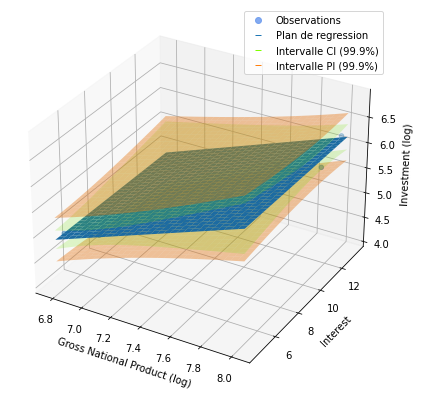

In [14]:
alpha = 0.001 #set alpha
resolution= 30 #set "resoltion" numer of data point on x and y

Xx = np.array(invest_df['log_gnp']).flatten()
Yy = np.array(invest_df['interest']).flatten()

XX = np.linspace(min(Xx), max(Xx), resolution)
YY = np.linspace(min(Yy), max(Yy), resolution)
xx, yy = np.meshgrid(XX, YY) # mesh x and y together
zz =  B[0] + B[1] *xx + B[2]*yy

#create empty placeholder for the mesh
threeD_CI_diff_top_z = np.empty((resolution,resolution))
threeD_CI_diff_bot_z = np.empty((resolution,resolution))
threeD_PI_diff_top_z = np.empty((resolution,resolution))
threeD_PI_diff_bot_z = np.empty((resolution,resolution))
# for multiple x,y data points measure CI (max,min) and PI(max,min)
for x in range(resolution):
    for y in range(resolution):
        log_gnp_value = xx[x,y]
        interest_value = yy[x,y]
        lin_reg_input = np.array([1, log_gnp_value, interest_value ]).reshape(3,1)
        threeD_CI_diff = ttest.ppf(1-alpha/2,n-3)*sigma*\
                         np.sqrt( np.linalg.multi_dot(
                             [ lin_reg_input.T, np.linalg.inv(np.dot(Z.T,Z)),lin_reg_input]))
        threeD_CI_diff_top_z[x,y] =  np.dot(lin_reg_input.T,B.T) + threeD_CI_diff
        threeD_CI_diff_bot_z[x,y] =  np.dot(lin_reg_input.T,B.T) - threeD_CI_diff
        threeD_PI_diff = ttest.ppf(1-alpha/2,n-3)*sigma*\
                         np.sqrt(1+ np.linalg.multi_dot(
                             [ lin_reg_input.T, np.linalg.inv(np.dot(Z.T,Z)),lin_reg_input]))
        threeD_PI_diff_top_z[x,y] =  np.dot(lin_reg_input.T,B.T) + threeD_PI_diff
        threeD_PI_diff_bot_z[x,y] =  np.dot(lin_reg_input.T,B.T) - threeD_PI_diff


#set labels
fig = plt.figure(figsize=(7,7))
ax = plt.axes(projection='3d')
ax.set_xlabel("Gross National Product (log)")
ax.set_ylabel("Interest")
ax.set_zlabel("Investment (log)")
#plot surfaces
ax.scatter3D(X_1, X_2, Y, 'gray')
ax.plot_surface(xx,yy,zz)
ax.plot_surface(xx,yy,threeD_CI_diff_top_z,color='#7FFF00',alpha=0.2, label='CI confidence Interval')
ax.plot_surface(xx,yy,threeD_CI_diff_bot_z,color='#7FFF00',alpha=0.2)
ax.plot_surface(xx,yy,threeD_PI_diff_top_z,color='tab:orange',alpha=0.4, label='PI confidence Interval')
ax.plot_surface(xx,yy,threeD_PI_diff_bot_z,color='tab:orange',alpha=0.4)
#create "dummy" legend
legend1 = mpl.lines.Line2D([0], [0], linestyle="none", c='cornflowerblue', alpha=0.8, marker='o')
legend2 = mpl.lines.Line2D([0], [0], linestyle="none", marker='_')
legend3 = mpl.lines.Line2D([0], [0], linestyle="none", c='#7FFF00', marker='_')
legend4 = mpl.lines.Line2D([0], [0], linestyle="none", c='tab:orange', marker='_')
ax.legend([legend1, legend2, legend3, legend4], ['Observations',
              'Plan de regression', 'Intervalle CI (99.9%)', 'Intervalle PI (99.9%)']);

13)En utilisant des classes/librairies existantes, donner les coefficients de régression, le coefficient de détermination ainsi que l’investissement prédit par le modèle quand GNP vaut 1000 et interest 10. La classe LinearRegression() de sklearn.linear_model est suggérée mais pas obligatoire. Vérifier que les valeurs calculées ici coïncident avec celles des questions précédentes.



In [15]:
X = invest_df[['log_gnp','interest']]
Y = invest_df['log_invest']


regr = linear_model.LinearRegression() #create linear model
regr.fit(X, Y) #fit the model to our data
r_value = r2_score(Y, regr.predict(X)) #measure r2 score
a = regr.predict([[np.log(1000), 10]]) #measure fitted linear regression to measure new data entry
print('The following tables displays a comparison between the measured values and the one given by scikit-learn')
data_13 = { 'Names' : ["My values", "scikit-learn"],
           "slope (\u03B8\u2081)" : [B[1], regr.coef_[0]],
            "slope (\u03B8\u2082)" : [B[2], regr.coef_[1]],
       "intercept" : [B[0], regr.intercept_],
         "r_value" : [r2, r_value],
            "Prediction for z = (1,1000,10)":[a[0],pred[0] ]}
displayFrame_13 = pd.DataFrame.from_dict(data_13).set_index('Names')
displayFrame_13.index.name = None # removes line "names" from display
displayFrame_13.head()

The following tables displays a comparison between the measured values and the one given by scikit-learn


,slope (θ₁),slope (θ₂),intercept,r_value,"Prediction for z = (1,1000,10)"
My values,1.051243,-0.006529,-2.180455,0.963311,5.015984
scikit-learn,1.051243,-0.006529,-2.180455,0.963311,5.015984


Resources used for this assignment:
http://reliawiki.org/index.php/Simple_Linear_Regression_Analysis#:~:text=2%5C%2C%5C!.-,t%20Tests,obtained%20in%20simple%20linear%20regression.&text=distribution%20is%20used%20to%20test,1%2C0%7D%5C%2C%5C!.
https://www.journaldunet.fr/web-tech/developpement/1441179-a-quoi-sert-matplotlib-inline-en-python/
https://stackoverflow.com/questions/44943646/jupyter-notebook-not-trusted
https://jakevdp.github.io/PythonDataScienceHandbook/04.12-three-dimensional-plotting.html